# Chunk downloading tests

In [1]:
!pip install boto3 matplotlib aioboto3 aiobotocore numcodecs
import boto3
import aioboto3
import asyncio
from botocore.config import Config
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

In [2]:
s3_client = boto3.client('s3', config=Config(max_pool_connections=512))

In [3]:
bucket="lifebit-user-data-1f2bfdf2-1d99-488c-9b87-246c62b66ea7"

## Check bucket and instance location

In [4]:
# Method 1: get_bucket_location
try:
    location = s3_client.get_bucket_location(Bucket=bucket)['LocationConstraint']
    # Note: None or null means us-east-1
    print(f"Bucket region: {location or 'us-east-1'}")
except Exception as e:
    print(f"Error: {e}")

# Method 2: head_bucket (check response headers)
try:
    response = s3_client.head_bucket(Bucket=bucket)
    region = response['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
    print(f"Bucket region: {region}")
except Exception as e:
    print(f"Error: {e}")

Error: SSL validation failed for https://s3.amazonaws.com/lifebit-user-data-1f2bfdf2-1d99-488c-9b87-246c62b66ea7?location [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)
Bucket region: eu-west-2


In [5]:
# Method 1: Using boto3
import boto3
region = boto3.Session().region_name
print(f"Region from boto3: {region}")

# Method 2: Query instance metadata service
import requests
try:
    r = requests.get('http://169.254.169.254/latest/meta-data/placement/region', timeout=1)
    print(f"Region from metadata: {r.text}")
except Exception as e:
    print(f"Metadata error: {e}")

# Method 3: Query instance metadata service v2 (if IMDSv2 is required)
try:
    token_response = requests.put('http://169.254.169.254/latest/api/token', 
                                headers={'X-aws-ec2-metadata-token-ttl-seconds': '21600'}, 
                                timeout=1)
    token = token_response.text
    r = requests.get('http://169.254.169.254/latest/meta-data/placement/region',
                    headers={'X-aws-ec2-metadata-token': token},
                    timeout=1)
    print(f"Region from IMDSv2: {r.text}")
except Exception as e:
    print(f"IMDSv2 error: {e}")

Region from boto3: None
Region from metadata: 
Region from IMDSv2: eu-west-2


### Both in eu-west-2

## Single process, single thread downloading

In [6]:
keys = [f"GEL-256534/call_AD/{i}/{j}/0" for i in range(4000) for j in range(4)]

In [7]:
import aioboto3

session = aioboto3.Session()

async with session.client('s3',config=Config(max_pool_connections=512)) as s3:
    async def fetch_single(key: str):
        response = await s3.get_object(Bucket=bucket, Key=key)
        data = await response['Body'].read()
        return len(data)
    
    start = time.time()
    print(f"Fetching {len(keys)} objects")
    results = await asyncio.gather(
        *[fetch_single(key) for key in keys],
    )
    elapsed = time.time() - start
    total_size = sum(results)

print(f"\nResults:")
print(f"Fetched {len(results)} objects in {elapsed:.2f}s")
print(f"Total data: {total_size/1000**3:.2f} GB")
print(f"Throughput: {total_size/elapsed/1000**2:.2f} MB/s")
print(f"Rate: {len(results)/elapsed:.2f} obj/s")

Fetching 16000 objects

Results:
Fetched 16000 objects in 107.01s
Total data: 20.89 GB
Throughput: 195.22 MB/s
Rate: 149.52 obj/s


### Asyncio in Python uses an event loop in single thread, so we're limited to a single core here.

## Single process, mutlithread

In [8]:
import boto3
from concurrent.futures import ThreadPoolExecutor
import time
import threading

s3 = boto3.client('s3',
    config=Config(
        max_pool_connections=1000,  # Increased from default
        connect_timeout=1,          # Faster timeout
        read_timeout=30,
        retries={'max_attempts': 0} # Disable retries for testing
    )
)

def fetch_object(key):
    try:
        start = time.time()
        data = s3.get_object(Bucket=bucket, Key=key)['Body'].read()
        size = len(data)
        elapsed = time.time() - start
        return size, elapsed
    except Exception as e:
        print(f"Error on {key}: {e}")
        return 0, 0

active = threading.active_count()
print(f"Initial thread count: {active}")

start = time.time()
sizes_and_times = []
with ThreadPoolExecutor(max_workers=512) as pool:
    sizes_and_times = list(pool.map(fetch_object, keys))

elapsed = time.time() - start
total_size = sum(size for size, _ in sizes_and_times)
successful_fetches = sum(1 for size, _ in sizes_and_times if size > 0)

print(f"\nResults:")
print(f"Fetched {successful_fetches}/{len(keys)} objects in {elapsed:.2f}s")
print(f"Total data: {total_size/1000**3:.2f} GB")
print(f"Throughput: {total_size/elapsed/1000**2:.2f} MB/s")
print(f"Rate: {successful_fetches/elapsed:.2f} obj/s")

# Show timing distribution
times = [t for _, t in sizes_and_times if t > 0]
if times:
    print(f"\nTiming stats (seconds):")
    print(f"Min: {min(times):.3f}")
    print(f"Max: {max(times):.3f}")
    print(f"Avg: {sum(times)/len(times):.3f}")

Initial thread count: 9
Error on GEL-256534/call_AD/2774/0/0: Connection was closed before we received a valid response from endpoint URL: "https://lifebit-user-data-1f2bfdf2-1d99-488c-9b87-246c62b66ea7.s3.eu-west-2.amazonaws.com/GEL-256534/call_AD/2774/0/0".

Results:
Fetched 15999/16000 objects in 75.81s
Total data: 20.89 GB
Throughput: 275.52 MB/s
Rate: 211.03 obj/s

Timing stats (seconds):
Min: 0.159
Max: 7.738
Avg: 2.219


### Meh, still not great - CPU use sits at about 250% as all the stuff boto is doing will be holding the GIL

## Single async loop in each of a set of parallel processes

In [9]:
import asyncio
import aioboto3
import multiprocessing as mp
from collections import defaultdict
import time
import os
from typing import List, Dict
import statistics
from dataclasses import dataclass
from concurrent.futures import ProcessPoolExecutor

@dataclass
class BatchStats:
    process_id: int
    start_time: float
    total_bytes: int
    files_completed: int
    duration: float = None
    
class S3BulkFetcher:
    def __init__(self, bucket: str, keys: List[str], num_processes: int = None, batch_size: int = 500):
        self.bucket = bucket
        self.keys = keys
        self.num_processes = num_processes or mp.cpu_count()
        self.batch_size = batch_size
        self.work_queue = mp.Queue()
        self.stats_queue = mp.Queue()
        
    def prepare_batches(self):
        batches = [
            self.keys[i:i+self.batch_size] 
            for i in range(0, len(self.keys), self.batch_size)
        ]
        for batch in batches:
            self.work_queue.put(batch)
            
        for _ in range(self.num_processes):
            self.work_queue.put(None)
    
    async def process_batch(self, batch: List[str], session) -> BatchStats:
        stats = BatchStats(
            process_id=os.getpid(),
            start_time=time.time(),
            total_bytes=0,
            files_completed=0
        )
        
        async with session.client('s3') as s3:
            async def fetch_single(key: str):
                try:
                    response = await s3.get_object(Bucket=self.bucket, Key=key)
                    data = await response['Body'].read()
                    return len(data), True
                except Exception as e:
                    print(f"Error processing {key}: {e}")
                    return 0, False
            
            results = await asyncio.gather(
                *[fetch_single(key) for key in batch],
                return_exceptions=False
            )
            
            for file_size, success in results:
                stats.total_bytes += file_size
                if success:
                    stats.files_completed += 1
                    
        stats.duration = time.time() - stats.start_time
        return stats
    
    async def worker_loop(self):
        session = aioboto3.Session()
        
        while True:
            batch = self.work_queue.get()
            if batch is None:  # sentinel value
                break
                
            stats = await self.process_batch(batch, session)
            self.stats_queue.put(stats)

    def worker_process(self):
        asyncio.run(self.worker_loop())

    def print_final_stats(self, all_stats: List[BatchStats], wall_time: float):
        total_bytes = sum(s.total_bytes for s in all_stats)
        total_files = sum(s.files_completed for s in all_stats)
        
        process_stats = defaultdict(lambda: {'bytes': 0, 'files': 0, 'batches': 0})
        for stat in all_stats:
            process_stats[stat.process_id]['bytes'] += stat.total_bytes
            process_stats[stat.process_id]['files'] += stat.files_completed
            process_stats[stat.process_id]['batches'] += 1

        batch_times = [s.duration for s in all_stats]
        
        #print("\n=== S3 Bulk Download Statistics ===")
        #print(f"\nOverall Performance:")
        #print(f"Total transfer: {total_bytes / 1024 / 1024:.2f} MB in {total_files} files")
        #print(f"Duration: {wall_time:.2f} seconds")
        #print(f"Throughput: {(total_bytes / 1024 / 1024) / wall_time:.2f} MB/s, "
        #      f"{total_files / wall_time:.1f} files/s")
        
        #print("\nBatch Statistics:")
        #print(f"Batch times - min: {min(batch_times):.2f}s, "
        #      f"max: {max(batch_times):.2f}s, "
        #      f"avg: {statistics.mean(batch_times):.2f}s")
        
        #print("\nPer-Process Performance:")
        #for pid, stats in process_stats.items():
        #    print(f"Process {pid}:")
        #    print(f"  Throughput: {(stats['bytes'] / 1024 / 1024) / wall_time:.2f} MB/s, "
        #          f"{stats['files'] / wall_time:.1f} files/s")
        #    print(f"  Processed: {stats['files']} files in {stats['batches']} batches")

    def run(self):
        start_time = time.time()
        
        # Prepare work batches
        self.prepare_batches()
        
        # Start worker processes
        processes = []
        for _ in range(self.num_processes):
            p = mp.Process(target=self.worker_process)
            p.start()
            processes.append(p)
            
        # Collect all stats
        all_stats = []
        stats_to_collect = len([b for b in self.keys[::self.batch_size]])
        
        while len(all_stats) < stats_to_collect:
            stats = self.stats_queue.get()
            all_stats.append(stats)
            
            # Optional: Print progress
            #if len(all_stats) % 10 == 0:
            #    print(f"Progress: {len(all_stats)}/{stats_to_collect} batches complete")
        
        # Wait for all processes to complete
        for p in processes:
            p.join()
            
        wall_time = time.time() - start_time
        
        # Print final statistics
        self.print_final_stats(all_stats, wall_time)
        
        return all_stats



In [10]:
def run_scaling_benchmark(
    fetcher_class,
    bucket,
    keys,
    batch_size,
    min_processes,
    max_processes
):
    process_counts = []
    throughputs = []
    
    n_proc = min_processes
    while n_proc <= max_processes:
        print(f"\nTesting with {n_proc} processes...")
        fetcher = fetcher_class(
            bucket=bucket,
            keys=keys[:n_proc*batch_size*4],
            num_processes=n_proc,
            batch_size=batch_size
        )
        
        start_time = time.time()
        stats = fetcher.run()
        duration = time.time() - start_time
        
        total_bytes = sum(s.total_bytes for s in stats)
        throughput = (total_bytes / 1000/ 1000) / duration  # MB/s
        
        process_counts.append(n_proc)
        throughputs.append(throughput)
        
        print(f"Throughput with {n_proc} processes: {throughput:.2f} MB/s")
        
        n_proc *= 2
        
    return process_counts, throughputs

def plot_scaling(process_counts, throughputs, title= "S3 Throughput Scaling"):
    plt.figure(figsize=(10, 6))
    plt.plot(process_counts, throughputs, 'bo-', linewidth=2, markersize=8)
    
    plt.xscale('log', base=2)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.xlabel("Number of Processes")
    plt.ylabel("Throughput (MB/s)")
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()


In [ ]:
# instance type = c5.9xlarge
process_counts, throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=500,
        min_processes=1,
        max_processes=64
    )
print(process_counts, throughputs)
plot_scaling(process_counts, throughputs)

In [ ]:
# instance type = c5n.9xlarge
process_counts, throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=500,
        min_processes=1,
        max_processes=64
    )
print(process_counts, throughputs)
plot_scaling(process_counts, throughputs)

/tmp/ipykernel_2779/2963857616.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([1, 2, 4, 8, 16, 32, 64], [162.80624306237462, 345.7732721919105, 658.9358771498762, 1062.419542658184, 1972.057722720383, 2541.4617122839895, 2523.501053909922], 'bo-', linewidth=2, markersize=8, label="c5n.9xlarge", color="red")


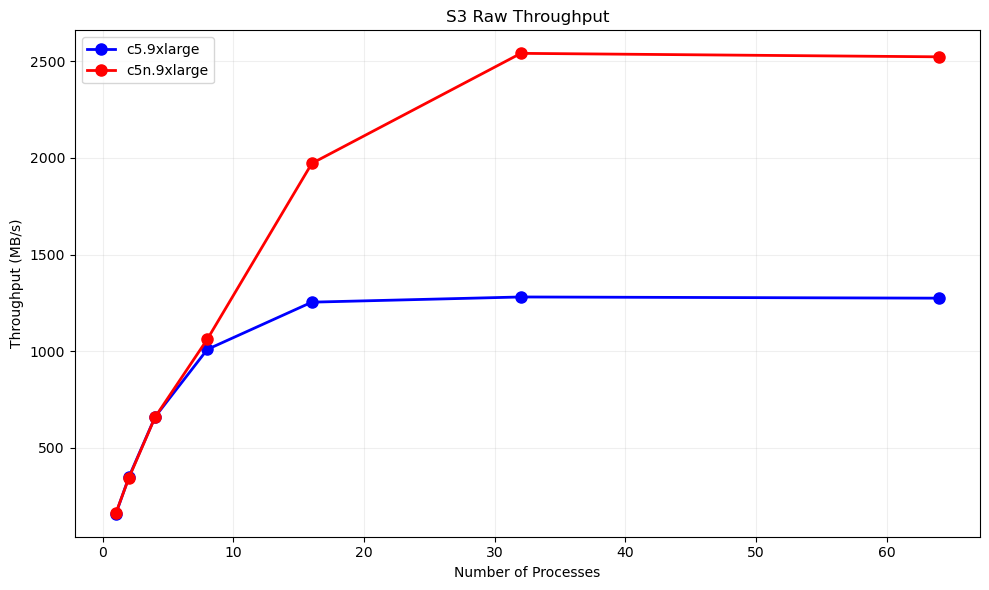

In [13]:
    plt.figure(figsize=(10, 6))
    plt.plot([1, 2, 4, 8, 16, 32, 64], [159.0341786762204, 349.88301727773677, 660.1621287063576, 1009.4825168651081, 1253.8112536680967, 1280.6974940263988, 1274.494689412922], 'bo-', linewidth=2, markersize=8, label="c5.9xlarge")
    plt.plot([1, 2, 4, 8, 16, 32, 64], [162.80624306237462, 345.7732721919105, 658.9358771498762, 1062.419542658184, 1972.057722720383, 2541.4617122839895, 2523.501053909922], 'bo-', linewidth=2, markersize=8, label="c5n.9xlarge", color="red")
    
    #plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.xlabel("Number of Processes")
    plt.ylabel("Throughput (MB/s)")
    plt.title("S3 Raw Throughput")
    
    plt.legend()
    plt.tight_layout()

### Yay, we're network bound.